In [144]:
# Leslie Huang

from datetime import datetime
import json
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
import nltk
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from odo import odo, discover, resource
import pandas as pd
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
import time

%matplotlib inline

In [2]:
data = odo("mongodb://localhost/my_mongo::reviews", 
            pd.DataFrame, dshape = "var * {unixReviewTime: int32, reviewText: string, summary: string, overall: float32, asin: string, reviewerID: string}")


In [10]:
# Convert to correct datetime format
data["date"] = pd.to_datetime(data["unixReviewTime"], unit = "s")

In [81]:
# Create a dummy for incentivized reviews

data["isIncentivized"] = pd.Series(data.reviewText.str.contains(r"( in exchange for my unbiased | in exchange for my honest | free or at a discount | free or discounted | Disclosure: | Disclaimer: | disclosure: | I received this product for free )"))

/Users/lesliehuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


In [82]:
data["isIncentivized"].value_counts()

False    11183883
True         1486
Name: isIncentivized, dtype: int64

In [29]:
print(data.dtypes)

unixReviewTime             int32
reviewText                object
summary                   object
overall                  float32
asin                      object
reviewerID                object
isIncentivized              bool
date              datetime64[ns]
dtype: object


In [83]:
data.head()

,unixReviewTime,reviewText,summary,overall,asin,reviewerID,isIncentivized,date
0,1349308800,Have you ever thought about how you met your b...,Lovely,4.0,0076144011,A210NOCSTBT4OD,False,2012-10-04
1,1300752000,"The butter dish is serving us well, and keepin...","Nice looking, and keeps the butter fresh",5.0,0130350591,A28ILV4TOG8BH2,False,2011-03-22
2,1214784000,I anxiously waited for the book I had pre orde...,Mother of the Bride,2.0,0307394530,A31B4D7URW4DNZ,False,2008-06-30
3,1277337600,"Fantastic book, a lot of good, original recipe...",amazing book,5.0,0307394530,A2HU0RPDRZZOP1,False,2010-06-24
4,1393113600,Can't wait to try all the amazing techniques. ...,Very helpful,5.0,0307394530,A7J0XOW7DYBBD,False,2014-02-23


In [84]:
data.shape

(11185369, 8)

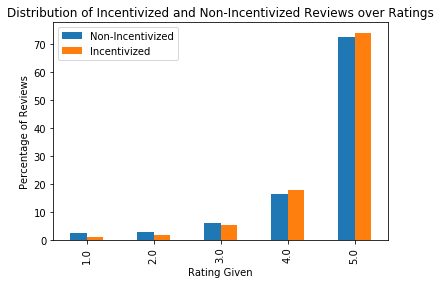

In [85]:
# Plot distributions of incentivized versus non-incentivized reviews

grouped = data.groupby(["isIncentivized", "overall"]).agg({"overall": "sum"})
grouped_percentages = grouped.groupby(level = 0).apply(lambda x: x / float(x.sum()) * 100)

grouped_percentages.unstack(0).plot.bar(title = "Distribution of Incentivized and Non-Incentivized Reviews over Ratings")
plt.legend(labels = ["Non-Incentivized", "Incentivized"])
plt.xlabel("Rating Given")
plt.ylabel("Percentage of Reviews")

(0, 6)

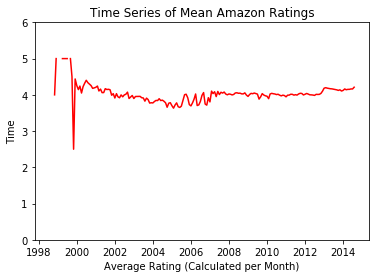

In [86]:
# Get daily mean / monthly mean of data for plotting
ts_df = data.groupby("date").agg({"overall": "mean"})
ts_df = ts_df.resample("M").mean()

plt.plot_date(ts_df.index.values, ts_df["overall"], fmt = "r-")

plt.title("Time Series of Mean Amazon Ratings")
plt.xlabel("Average Rating (Calculated per Month)")
plt.ylabel("Time")
plt.ylim(0, 6)

In [53]:
# Create stemmer for DFM creation

stemmer = SnowballStemmer("english")
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


In [101]:
# Now let's create a training set of reviews with disclaimer language AND high ratings, and reviews with one-star ratings

incentivized = data[(data["isIncentivized"] == True) & (data["overall"] >= 4.0)]

In [102]:
incentivized.head()

,unixReviewTime,reviewText,summary,overall,asin,reviewerID,isIncentivized,date
39248,1359504000,I think that I have tried cooking chicken ever...,Best Chicken Ever,5.0,B00004RFQL,A1HQSUVHWAL6XY,True,2013-01-30
92986,1303171200,Absolutely LOVE this waffle iron! It is much ...,Nordicware waffle iron is easy to use and compact,5.0,B00004W4UE,A1JGDGXA38JS2,True,2011-04-19
119357,1128729600,One of the drawbacks of reading these reviews ...,Almost perfect,4.0,B00005AC58,A8X0J4RHGZ1KD,True,2005-10-08
126618,1278374400,This is my second purchase of this product. I ...,Peace of Mind,5.0,B00005B8K5,A36M8SJXSXGOK7,True,2010-07-06
148973,1326758400,Full disclosure: I might love this knife more ...,Great knife,5.0,B00005MEGZ,A13HCMMJSCXDTY,True,2012-01-17


In [157]:
one_star_sample = data[data["overall"] == 1.0].sample(n = 1500)
one_star_sample.head()

,unixReviewTime,reviewText,summary,overall,asin,reviewerID,isIncentivized,date
8231020,1065657600,Should have read the reviews here before I pur...,Looks good that's about it...,1.0,B00005A449,AQB6E00RKXRWE,False,2003-10-09
205800,1398124800,I couldn't use it as it has an ?American plug....,Don't buy this!!,1.0,B00006F2MD,A281M0EEOZR28A,False,2014-04-22
3137378,1380240000,I needed to wash it and I did proper care and ...,Can't wash it!,1.0,B0058DFJYQ,A31XRLDOX93KTG,False,2013-09-27
4694868,1385856000,This pins do not hold your hair up. They're ve...,They don't work.,1.0,B000V8I38M,ACT7BAKTUG3GN,False,2013-12-01
6297538,1387324800,"Basically, it doesn't work.Nothing beats a ham...",PRRFFT,1.0,B0000224S8,ATSB3Y6YFJANI,False,2013-12-18


In [110]:
# Create our training set from the bad reviews and the incentivized ones
training_set = pd.concat([one_star_sample, incentivized])
training_classifications = training_set.isIncentivized

In [147]:
# Pipeline to construct DTM, convert to tf-idf, and then create classifier

clf_pipe = Pipeline([
                    ("dfm", CountVectorizer(analyzer=stemmed_words)),
                    ("tf-idf", TfidfTransformer()),
                    ("clf", MultinomialNB())
                    ]
                    )

In [148]:
# Make the classifier

classifier = clf_pipe.fit(training_set["reviewText"], training_classifications)

In [128]:
# Now let's create a test set from some 3-star reviews

test_set = data[data["overall"] == 3.0].sample(n = 1000)

(1000, 10318)

In [152]:
# Predict classification of the test set

predicted = classifier.predict(test_set["reviewText"])

In [153]:
test_set["predicted_cat"] = predicted

In [154]:
test_set.head()

,unixReviewTime,reviewText,summary,overall,asin,reviewerID,isIncentivized,date,predicted_cat
3148442,1365552000,I wanted a chip maker that gave me healthier c...,Good for good health,3.0,B005AV0RVQ,ADD9RPVMUOV87,False,2013-04-10,False
5149111,1393891200,Great price. But the iron Broke within 3 month...,You get what you pay for.,3.0,B002NGMF6Q,A13UJH0NQIY5SG,False,2014-03-04,False
973892,1237939200,"This is a very nice, high-quality item. I pur...",May not be suitable for the beach...,3.0,B000GPRLSI,A29N23Q2EE3SWK,False,2009-03-25,False
10469812,1374192000,"People say it takes about 4 weeks to work, for...",Not Sure??,3.0,B006JHQRPA,A1JE7PUM5I3R5F,False,2013-07-19,True
1937699,1298592000,"Okay, the dog piece tool; worthless. However, ...",Easier to Brush Fido,3.0,B001U0ONB6,A14N6VRMTWXP79,False,2011-02-25,False


In [155]:
# Suspicious reviews

suspicious = test_set[test_set["isIncentivized"] != test_set["predicted_cat"]]

In [156]:
suspicious.head()

,unixReviewTime,reviewText,summary,overall,asin,reviewerID,isIncentivized,date,predicted_cat
10469812,1374192000,"People say it takes about 4 weeks to work, for...",Not Sure??,3.0,B006JHQRPA,A1JE7PUM5I3R5F,False,2013-07-19,True
1576842,1357084800,Overall A good product. However the initial us...,"Good Product, Two Negatives.",3.0,B00176B96U,A2DVNPCW13TM02,False,2013-01-02,True
10312665,1376870400,4 stars for quality fit and comfort - minus on...,"Top Tier Sock, But Very High Price",3.0,B00591WBE8,A15IULIO4OCC4A,False,2013-08-19,True
9129341,1358035200,Just okay. The product was not worth the pric...,Not worth the price,3.0,B0015NZ6FK,A9QEP1HOR9VZL,False,2013-01-13,True
2343696,1381449600,I was expecting a more &#34;golden&#34; oak fi...,ok but has some minor issues,3.0,B0030NS9BG,A2DGHNNPG7LC,False,2013-10-11,True
